
              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 28 2023 11:53:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Mar 26 13:04:13 NodeManager::prepare_nodes [Info]: 
    Preparing 184 nodes for simulation.

Mar 26 13:04:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 184
    Simulation time (ms): 17988
    Number of OpenMP threads: 1
    Not using MPI

Mar 26 13:04:14 SimulationManager::run [Info]: 
    Simulation finished.


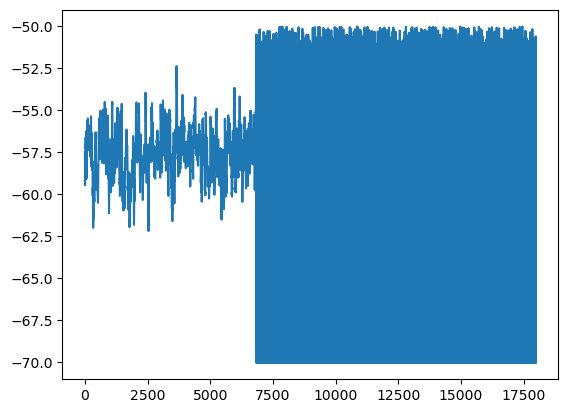

In [1]:
import pandas as pd
import numpy as np
from scripts import neuron_categorization, optimization, model, visualizations, preprocessing
import matplotlib.pyplot as plt

spike_trains = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/spikes/S_3_p.npy')
calcium_traces = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')
ez_track_data = pd.read_csv('/hpc/mzhu843/modelling/nest/DATA/raw/ezytrack/behaviour_LocationOutput.csv')

categorizer = neuron_categorization.NeuronCategorizer(spike_trains, calcium_traces, ez_track_data)
categorizer.run_categorization()

weights = optimization.initialize_connectivity_matrix_normal_distribution(categorizer.get_categorized_neurons())

model = model.NeuronalNetwork(weights, categorizer.get_categorized_neurons(), G_e=4)

model.simulate()

voltages_trace_pyr = model.voltage_traces_pyr



ts = range(len(voltages_trace_pyr[2]))


plt.plot(ts, voltages_trace_pyr[2])
plt.show()










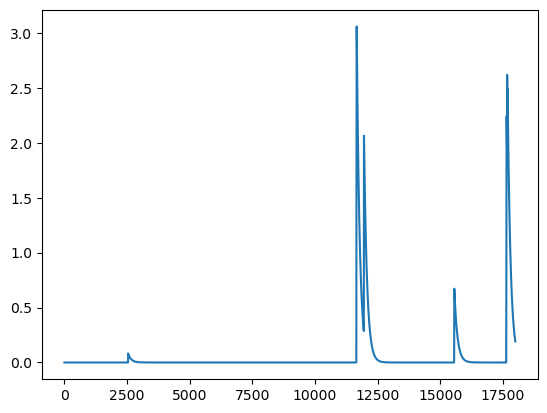

In [2]:
import numpy as np
import matplotlib.pyplot as plt

calcium = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')
plt.plot(calcium[0])


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 28 2023 11:53:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Mar 26 13:05:41 NodeManager::prepare_nodes [Info]: 
    Preparing 14 nodes for simulation.

Mar 26 13:05:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Mar 26 13:05:41 SimulationManager::run [Info]: 
    Simulation finished.


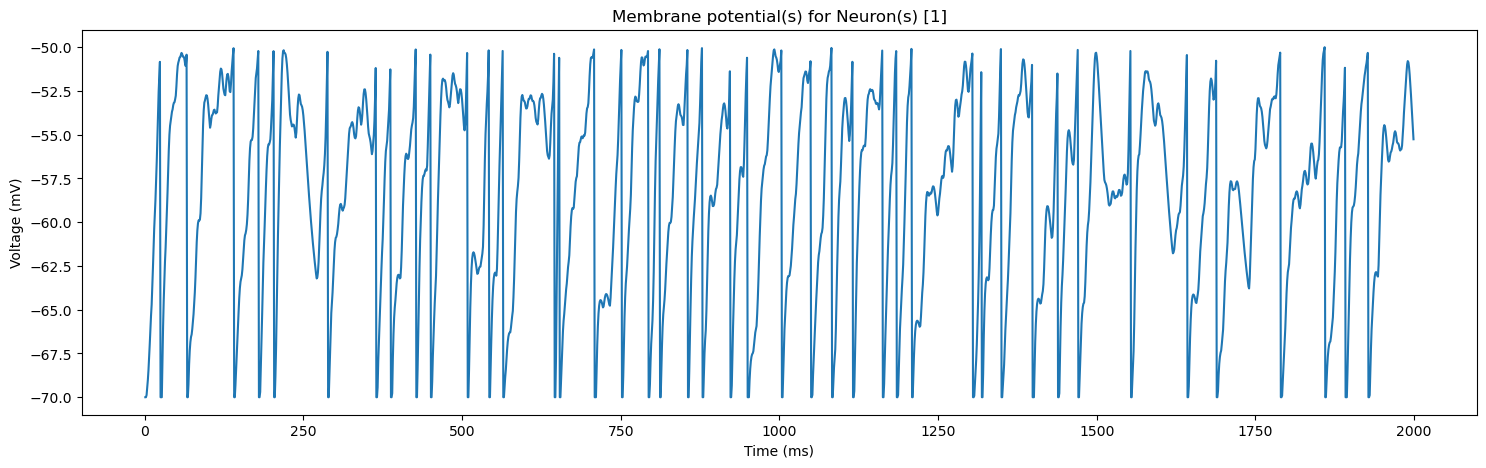

In [1]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from scripts import visualizations

pyr = nest.Create('iaf_psc_alpha', n=1, params=pyr_hcamp_deco2012.params)
external_input = nest.Create('poisson_generator', n=10)
external_input.set(rate=40)

external_parrot = nest.Create('parrot_neuron', n=1)


nest.Connect(external_input, external_parrot)
nest.Connect(external_parrot, pyr, syn_spec={'weight': 150})

Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, pyr)

spike_recorder = nest.Create('spike_recorder')
nest.Connect(pyr, spike_recorder)

nest.Simulate(2000)

visualizations.plot_vms_from_device(Vm_recorder, [1])



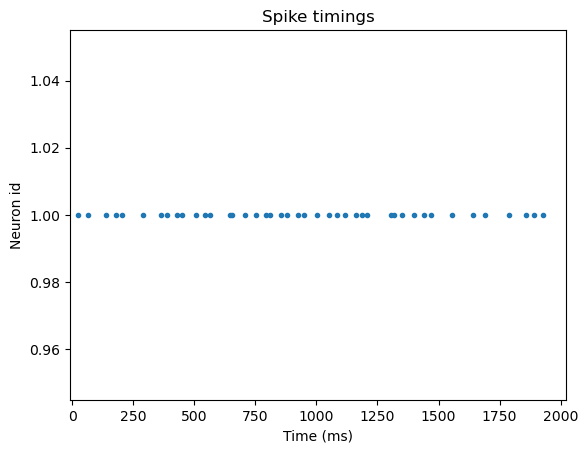

In [2]:
visualizations.plot_spikes_from_device(spike_recorder) 

In [12]:
events = Vm_recorder.get('events')['V_m']
count = 0
for num in events:
    print(num)

-70.0
-70.0
-69.87242142560255
-69.46114330720712
-69.01429064452546
-68.44299916432823
-67.73578444446609
-66.95800248688454
-66.07733400897096
-65.33668030294325
-64.70993100951844
-63.750988383946435
-62.628685484397984
-61.39900380392847
-60.37095728205228
-59.58983375158137
-58.70930816033761
-57.70720010424567
-56.53715980384129
-55.14957488639083
-53.716618026503646
-52.556399454843856
-51.68626799216314
-50.83576528446761
-70.0
-70.0
-70.0
-67.88247439905498
-65.9614335595269
-64.47426374734066
-63.31074281022155
-62.24859699455823
-61.437073146673384
-60.427102877617735
-59.28750037909217
-58.30078801808898
-57.055088973811294
-55.860117180425256
-54.98847684173407
-54.48517110209039
-54.20775566857233
-53.88241740766944
-53.684859553584346
-53.54966354244798
-53.30926438602984
-53.17525156340787
-53.14624719294753
-52.9763313224925
-52.77005196443693
-52.223727833059
-51.54942052994953
-51.072043898949815
-50.8757496362889
-50.74501729079001
-50.58744953941161
-50.56576852454